# OLS Regression Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, make_scorer

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Import data

In [3]:
covid = pd.read_hdf('./Covid_data/covid_df.hdf')
pop = pd.read_hdf('./Covid_data/population_df.hdf')
covid_per_cap = pd.read_hdf('./Covid_data/covid_per_cap_df.hdf')
ga_sent = pd.read_hdf('./data/processed/ga_sentiment_mean.hdf')

#### Calculate OLS model r2 scores and plot covid metrics and difference metrics for a single state

> Loop of 6 possible target variables (cases per capita, deaths per capita, cases per capita 1st difference, deaths per capita 1st difference, cases per capita 2nd difference, deaths per capita 2nd difference. 
>
> Trained on 28 features. 4 sentiment measures (polarity mean, subjectivity mean, polarity standard deviation, subjectivity standard deviation) At 7 different time lags (no lag, 1day, 2day, 3day, 4day, 5day, 6day)

In [11]:
def state_analysis(covid_df, sent_df, state_string):
    
    # make sure datasets are looking at same date slice
    covid_df = covid_df[pd.datetime(2020,3,19):pd.datetime(2020,8,4)]
    sent_df = sent_df[pd.datetime(2020,3,19):pd.datetime(2020,8,4)]

    # create 1st order and 2nd order difference metrics
    covid_ca = covid_df[[f'{state_string}_cases', f'{state_string}_deaths']]
    covid_ca[[f'{state_string}_cases_diff1', f'{state_string}_deaths_diff1']] = covid_df[[f'{state_string}_cases', f'{state_string}_deaths']].diff()
    covid_ca[[f'{state_string}_cases_diff2', f'{state_string}_deaths_diff2']] = covid_df[[f'{state_string}_cases', f'{state_string}_deaths']].diff().diff()
    covid_ca = covid_ca.dropna()

    # create 6 panel subplots of covid data
    fig =  plt.figure(figsize = (15,15))
    fig.add_subplot(3,2,1)
    covid_ca[f'{state_string}_cases'].plot()
    fig.add_subplot(3,2,3)
    covid_ca[f'{state_string}_cases_diff1'].plot()
    fig.add_subplot(3,2,5)
    covid_ca[f'{state_string}_cases_diff2'].plot();
    fig.add_subplot(3,2,2)
    covid_ca[f'{state_string}_deaths'].plot(color='red')
    fig.add_subplot(3,2,4)
    covid_ca[f'{state_string}_deaths_diff1'].plot(color='red')
    fig.add_subplot(3,2,6)
    covid_ca[f'{state_string}_deaths_diff2'].plot(color='red');

    # concatenate sentiment and covid data for modeling
    model_df = pd.concat([sent_df, covid_ca], axis=1)
    model_df = model_df.dropna()
    
    # run OLS model for all six possible target vars
    print('R2 scores, not cross-validated, or train_test_split')
    for i in range(6):
        X = model_df[['TB_polarity', 'TB_subjectivity', 'TB_polarity_std', 'TB_subjectivity_std']]
        X = pd.concat([X,X.shift(1),X.shift(2),X.shift(3),X.shift(4),X.shift(5),X.shift(6)], axis=1)
        X = X.dropna()
        y = model_df.iloc[6:, 4+i]
        lr = LinearRegression()
        model = lr.fit(X, y)
        y_pred = model.predict(X)
        print(f'{model_df.columns[4+i]} r2 score: {r2_score(y, y_pred)}')

    # run the same model but add cross-validation
    print('\n R2 scores, cross-validated')
    for i in range(6):
        X = model_df[['TB_polarity', 'TB_subjectivity', 'TB_polarity_std', 'TB_subjectivity_std']]
        X = pd.concat([X,X.shift(1),X.shift(2),X.shift(3),X.shift(4),X.shift(5),X.shift(6)], axis=1)
        X = X.dropna()
        y = model_df.iloc[6:, 4+i]
        lr = LinearRegression()
        model = lr.fit(X, y)
        print(f'{model_df.columns[4+i]} cross-val r2 score: {cross_val_score(model, X, y, cv=3).mean()}')

/Users/henryvalk/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


R2 scores, not cross-validated, or train_test_split
Georgia_cases r2 score: 0.502723336657759
Georgia_deaths r2 score: 0.6723229083567699
Georgia_cases_diff1 r2 score: 0.3556487817532815
Georgia_deaths_diff1 r2 score: 0.242331097569771
Georgia_cases_diff2 r2 score: 0.17971123543042178
Georgia_deaths_diff2 r2 score: 0.26053886142097715

 R2 scores, cross-validated
Georgia_cases cross-val r2 score: -17.977818852292412
Georgia_deaths cross-val r2 score: -6.325743920489317
Georgia_cases_diff1 cross-val r2 score: -12.340179087873894
Georgia_deaths_diff1 cross-val r2 score: -0.6054172039971101
Georgia_cases_diff2 cross-val r2 score: -2.4537124045616063
Georgia_deaths_diff2 cross-val r2 score: -0.6362374265099855


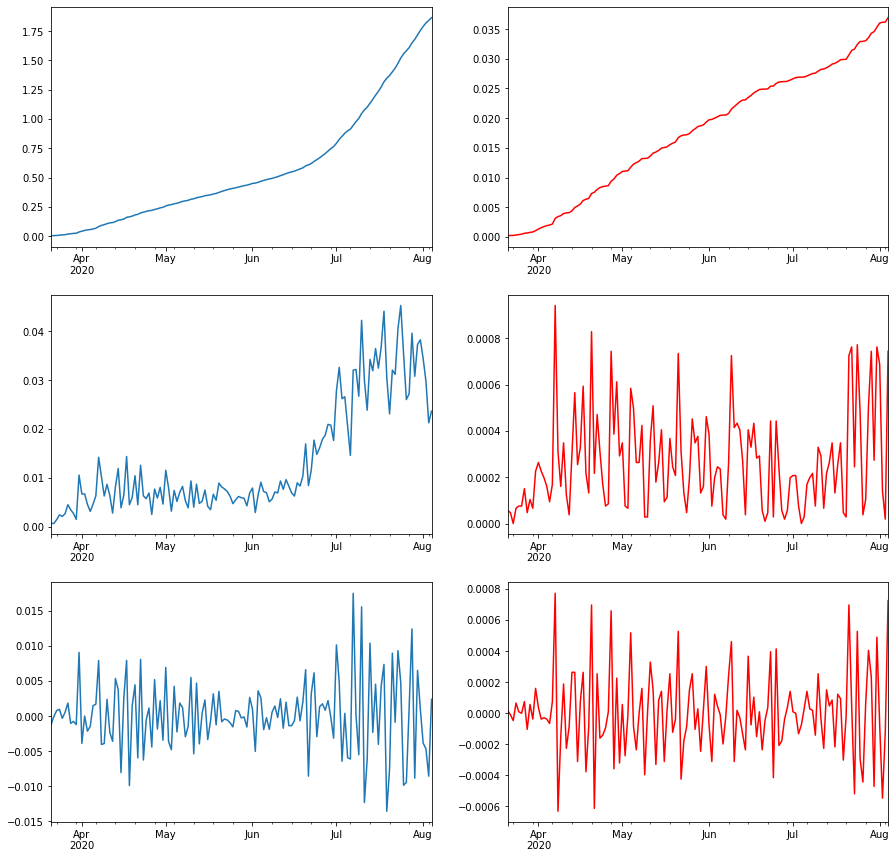

In [12]:
state_analysis(covid_per_cap, ga_sent, 'Georgia')

# Covid / Twitter Cross-Correlation

> compute a correlation between the entire polarity array and the covid 1st difference array. Then lags each array forward and backward with respect to the other. This will determine the lag where these signals are most correlated and justify the decision to use lagged sentiment data in the ols model.

In [6]:
covid_per_cap = pd.read_hdf('./Covid_data/covid_per_cap_df.hdf')

def state_xcorr(covid_df, state_string, state_abbrev):

    sent_df = pd.read_hdf(f'./data/processed/{state_abbrev}_sentiment_mean.hdf')

    covid_df = covid_df[pd.datetime(2020,3,19):pd.datetime(2020,8,4)]
    sent_df = sent_df[pd.datetime(2020,3,19):pd.datetime(2020,8,4)]

    covid_ca = covid_df[[f'{state_string}_cases', f'{state_string}_deaths']]
    covid_ca[[f'{state_string}_cases_diff1', f'{state_string}_deaths_diff1']] = covid_df[[f'{state_string}_cases', f'{state_string}_deaths']].diff()
    covid_ca[[f'{state_string}_cases_diff2', f'{state_string}_deaths_diff2']] = covid_df[[f'{state_string}_cases', f'{state_string}_deaths']].diff().diff()
    covid_ca = covid_ca.dropna()
    
    model_df = pd.concat([sent_df, covid_ca], axis=1)
    model_df = model_df.dropna()

    X = model_df['TB_polarity']
    y = model_df[f'{state_string}_cases_diff1']

    lags, c, line, b = plt.xcorr(X, y)
    
    return lags, c

/Users/henryvalk/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


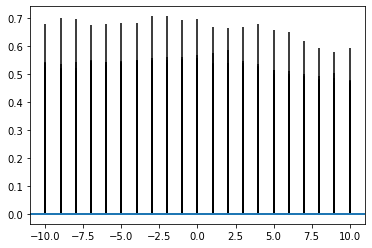

In [7]:

lags1, c1 = state_xcorr(covid_per_cap, 'New_York', 'ny')
lags2, c2 = state_xcorr(covid_per_cap, 'California', 'ca')
lags3, c3 = state_xcorr(covid_per_cap, 'Florida', 'fl')
lags4, c4 = state_xcorr(covid_per_cap, 'Georgia', 'ga')
lags5, c5 = state_xcorr(covid_per_cap, 'Texas', 'tx')

#### Plot the minus 10 day / plus 10 day covid, twitter sentiment cross correlation for each state

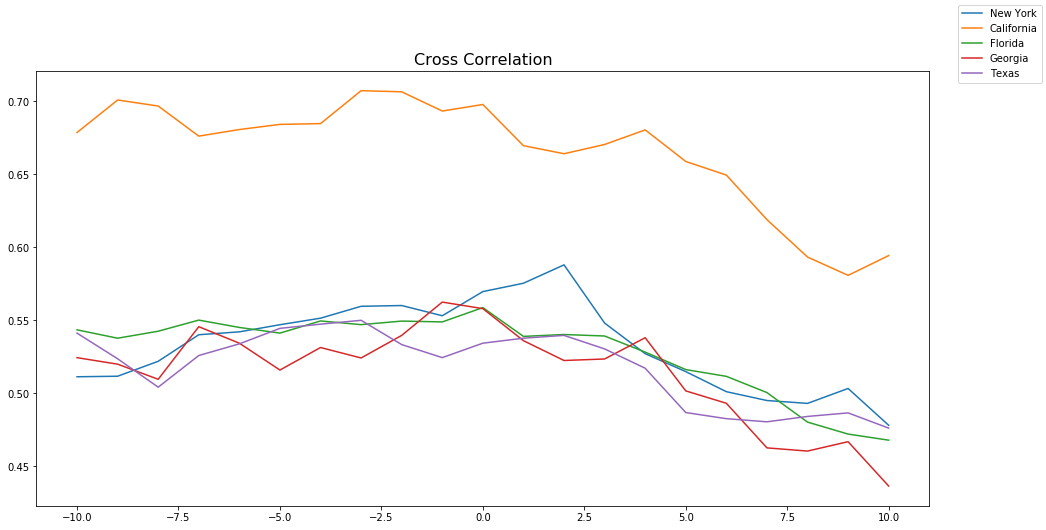

In [14]:
fig = plt.figure(figsize=(16,8))
plt.plot(lags1, c1); # ny
plt.plot(lags2, c2); # ca
plt.plot(lags3, c3); # fl
plt.plot(lags4, c4); # ga
plt.plot(lags5, c5); # tx
fig.legend(['New York', 'California', 'Florida', 'Georgia', 'Texas'])
plt.title('Cross Correlation', fontsize=16)
plt.show()